In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
Train = pd.read_csv("train.csv")

# Analyse exploratoire

<Axes: >

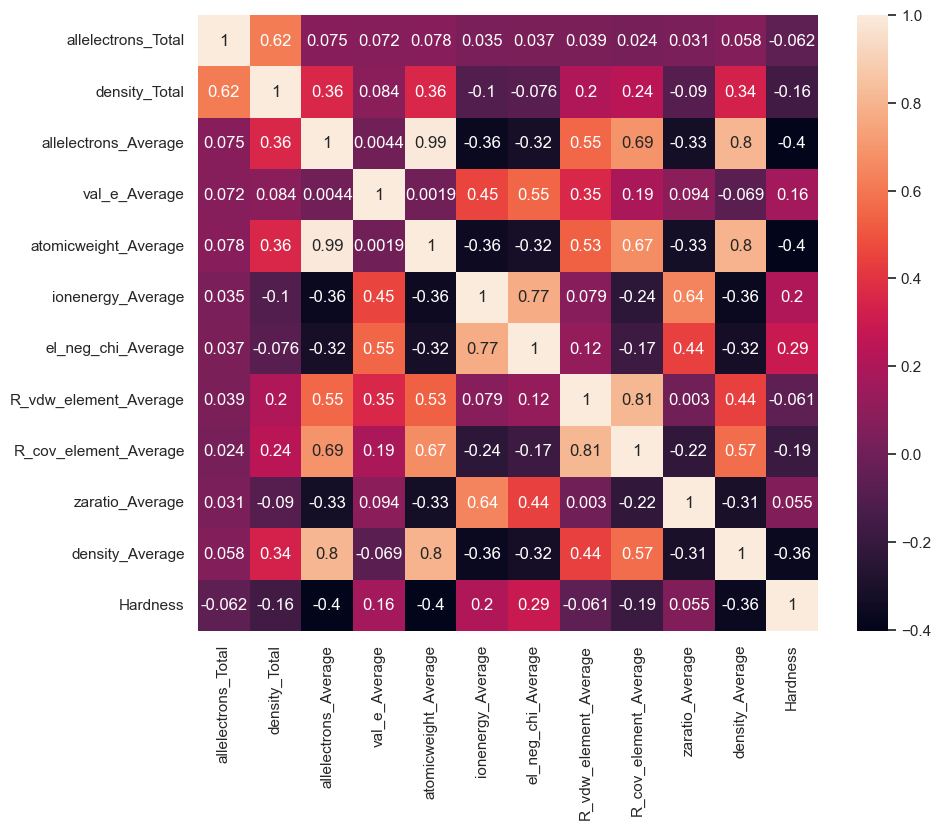

In [10]:
sns.set(rc = {'figure.figsize':(10,8)})
Correlations = Train.select_dtypes(include=['boolean','number']).drop(columns=['id']).corr()
sns.heatmap(Correlations, annot=True)

In [ ]:
#sns.histplot(data=Train, x='allelectrons_Total', hue='Hardness')
#plt.show()

C:\Users\taeud\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


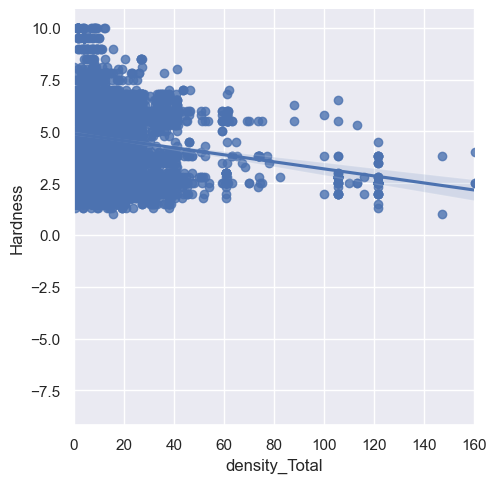

In [11]:
x_max = 160
sns.lmplot(data=Train, x='density_Total', y='Hardness')
plt.xlim(0, x_max)
plt.show()

C:\Users\taeud\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


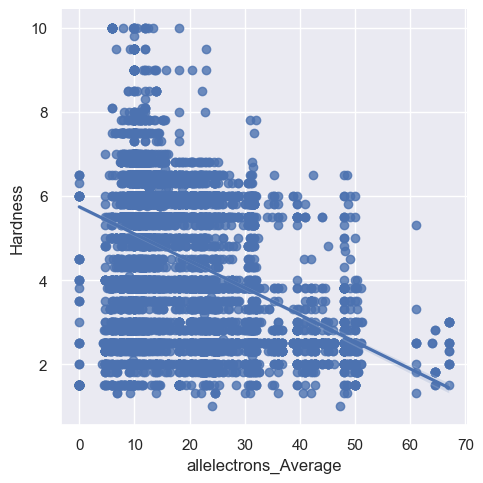

In [12]:
x_max = 160
sns.lmplot(data=Train, x='allelectrons_Average', y='Hardness')
#plt.xlim(0, x_max)
plt.show()

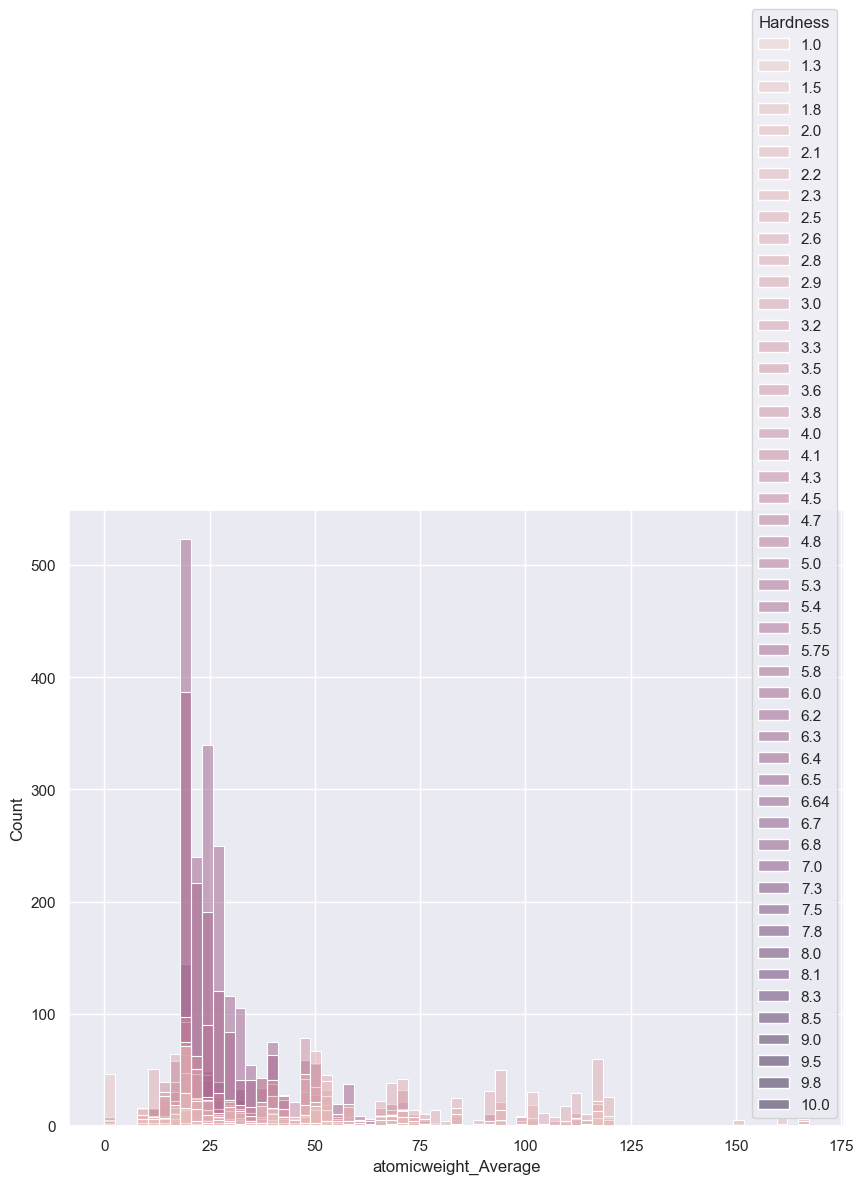

In [13]:
sns.histplot(data=Train, x='atomicweight_Average', hue='Hardness')
plt.show()

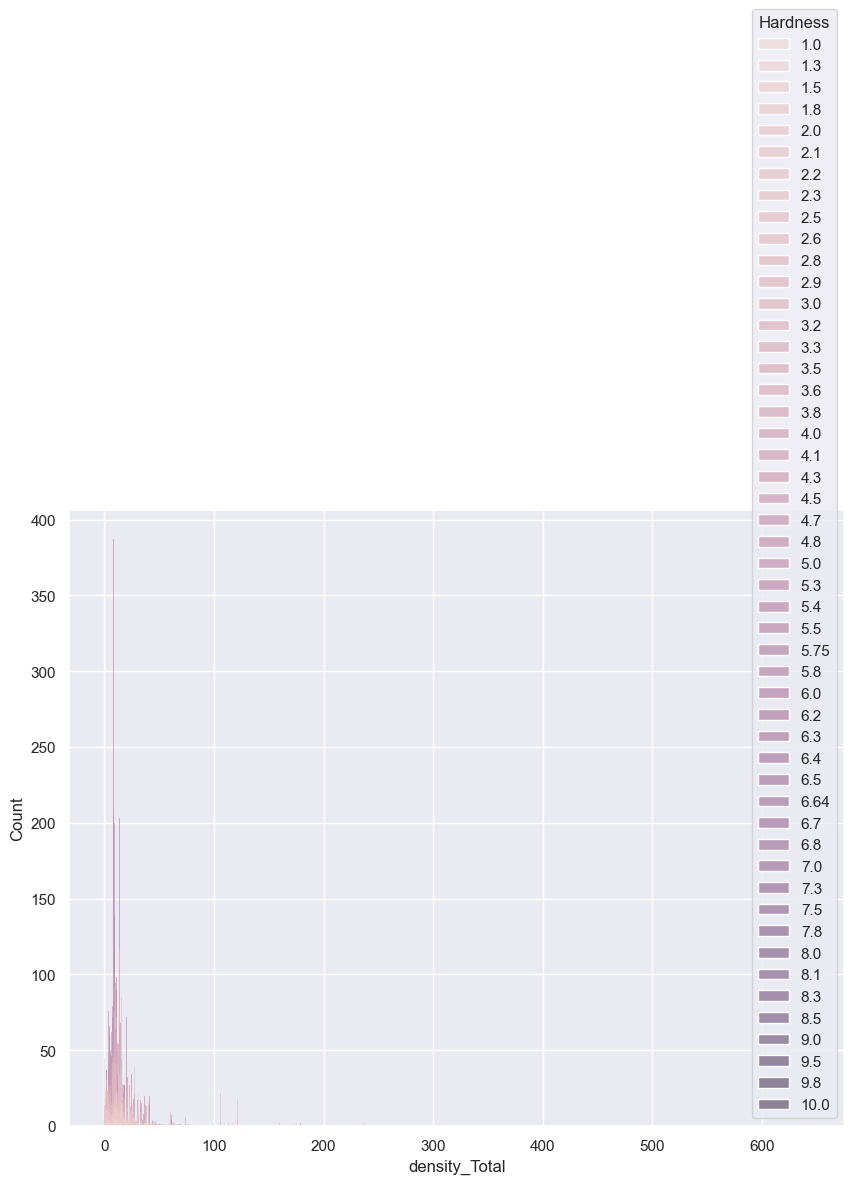

In [14]:
sns.histplot(data=Train, x='density_Total', hue='Hardness')
plt.show()

# Elaboration du modèle

In [29]:
import xgboost as xgb
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split

In [30]:
X, Y = Train.drop("Hardness", axis=1), Train['Hardness']

In [41]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y, random_state=1)

In [32]:
dtrain = xgb.DMatrix(X_Train, Y_Train, enable_categorical=True)
dtest  = xgb.DMatrix(X_Test, Y_Test, enable_categorical=True)

In [43]:
#Recherche du learning rate
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance

# Dictionnaire d'hyperparamètres - Minimisation de la MSE, utilisation du gpu pour la construction d'arbres
params = {"objective": "reg:squarederror", 
          "tree_method": "gpu_hist",
          "eta":"0.01",
          "eval_metric":"rmsle"
         } #binary:logistic
evals = [(dtrain, "train"), (dtest, "validation")]
n = 1000

model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10, #Evaluation tous les 5 rounds
   early_stopping_rounds=50 #Arrêt si non amélioration des résultats après 50 rounds
)
#nb boosting rounds = 470

[0]	train-rmsle:1.28865	validation-rmsle:1.29271
[10]	train-rmsle:1.06360	validation-rmsle:1.07023
[20]	train-rmsle:0.89991	validation-rmsle:0.90847
[30]	train-rmsle:0.77454	validation-rmsle:0.78479
[40]	train-rmsle:0.67541	validation-rmsle:0.68720
[50]	train-rmsle:0.59509	validation-rmsle:0.60824
[60]	train-rmsle:0.52933	validation-rmsle:0.54379
[70]	train-rmsle:0.47503	validation-rmsle:0.49077
[80]	train-rmsle:0.42994	validation-rmsle:0.44691
[90]	train-rmsle:0.39235	validation-rmsle:0.41054
[100]	train-rmsle:0.36100	validation-rmsle:0.38031
[110]	train-rmsle:0.33484	validation-rmsle:0.35548
[120]	train-rmsle:0.31298	validation-rmsle:0.33502
[130]	train-rmsle:0.29468	validation-rmsle:0.31811
[140]	train-rmsle:0.27958	validation-rmsle:0.30419
[150]	train-rmsle:0.26703	validation-rmsle:0.29281
[160]	train-rmsle:0.25671	validation-rmsle:0.28354
[170]	train-rmsle:0.24825	validation-rmsle:0.27599
[180]	train-rmsle:0.24127	validation-rmsle:0.27000
[190]	train-rmsle:0.23556	validation-rmsle

In [42]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')

from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.05]}


# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_Train, Y_Train)

print("The best hyperparameters are ",search.best_params_)

#The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 700} -- 470 voir code au dessus

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 700}


In [52]:
regressor = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = 470 ,
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')



In [54]:
regressor.fit(X_Train, Y_Train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=470, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Application sur l'echantillon test

In [46]:
Test = pd.read_csv("test.csv")

In [57]:
predictions = regressor.predict(Test)
predictions = predictions.round(3)

In [60]:
output = pd.DataFrame({"id":Test.id, "Hardness":predictions})
output.to_csv('submission.csv', index=False)

In [63]:
output

,id,Hardness
0,10407,3.105
1,10408,3.112
2,10409,5.957
3,10410,4.625
4,10411,4.875
...,...,...
6934,17341,5.772
6935,17342,4.326
6936,17343,5.467
6937,17344,4.215


In [62]:
Test

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.360000,5.280000,82.561240,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.000000,5.600000,39.568056,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.600000,4.800000,23.231818,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.000000,4.800000,20.298893,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.000000,4.000000,22.977675,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456
...,...,...,...,...,...,...,...,...,...,...,...,...
6934,17341,446.0,36.135392,9.636364,4.636364,19.689448,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548
6935,17342,36.0,3.550000,18.000000,4.000000,36.068500,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045
6936,17343,68.0,4.545328,11.333333,5.333333,22.688853,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425
6937,17344,40.0,2.334164,6.666667,4.000000,13.016128,12.700467,2.770000,1.476667,0.616667,0.663797,0.51227
